In [85]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
datos = "https://raw.githubusercontent.com/hhsieh2416/Identify_Diabetic_Complications/main/data/diabetes_notes.csv"
df = pd.read_csv(datos)

In [79]:
## Importamos paqueterias
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [80]:
#Lectura de datos
datos = "https://raw.githubusercontent.com/hhsieh2416/Identify_Diabetic_Complications/main/data/diabetes_notes.csv"
df = pd.read_csv(datos)

Media de palabras: 610.5035460992908
Mediana de palabras: 541.0
Minimo de palabras: 163
Maximo de palabras: 1930


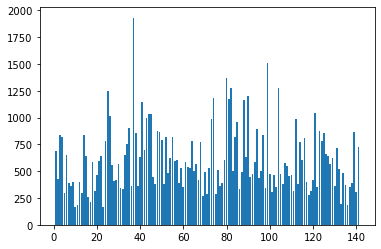

In [81]:
# Analisis grafico de los datos
fig, ax = plt.subplots()
ax.bar(df['NOTE_ID'],df['TEXT'].str.split().apply(len))

# Cantidad de palabras por reporte de cada paciente identificado por un id
conteo = df['TEXT'].str.split().apply(len).tolist()
print('Media de palabras: ' + str(np.mean(conteo)))
print('Mediana de palabras: ' + str(np.median(conteo)))
print('Minimo de palabras: ' + str(np.min(conteo)))
print('Maximo de palabras: ' + str(np.max(conteo)))

In [82]:
def reporte_paciente(id):
    resumen = re.findall(r"\w+", str(df[df.NOTE_ID == id]['TEXT'].tolist() ))
    return resumen

In [84]:
# print(reporte_paciente(1))

# Función sin expresiones regex

In [86]:
def extract_text_window(df, word, window_size, column_name = "TEXT"):
    
    #Constants
    user_input = f'({word})'
    regex = re.compile(user_input)
    
    negative = f'(no history of {word}|No history of {word}|any comorbid complications|family history|father also has {word}|denies {word}|Negative for {word})'
    regex_negative = re.compile(negative)
    
    half_window_size = window_size 
    final_df = pd.DataFrame([])
    column_position = df.columns.get_loc(column_name) + 1  #We add 1 cause position 0 is the index
    
    
    #Loop for each row of the column
    for row in df.itertuples():
        
        #Loop for multiple matches in the same row
        for match in regex.finditer(row[column_position]):

            window_start = int([match.start()-half_window_size if match.start()>=half_window_size else 0][0])
            window_end = int([match.end() + half_window_size if match.end()+half_window_size <= len(row[column_position]) else len(row[column_position])][0])
            

            final_df = final_df.append({
                                        "WORD": match.group(),
                                        "START_INDEX": match.start(),
                                        "WINDOW_START": window_start,
                                        "WINDOW_END": window_end,
                                        "CONTEXT": row[column_position][window_start:window_end],
                                        "FULL_TEXT": row[column_position],
                                        "NOTE_ID": row[1]},
                                        ignore_index=True)
    #Extracción de negativos
        for match in regex_negative.finditer(row[column_position]):
            final_df2 = final_df[final_df["CONTEXT"].str.contains(pat = regex_negative, regex = True)==False]

    return "No matches for the pattern" if len(final_df) == 0 else  final_df2

In [87]:
df = pd.read_csv("https://raw.githubusercontent.com/hhsieh2416/Identify_Diabetic_Complications/main/data/diabetes_notes.csv")
word = "diabet"
window_size = 50

diabetes_notes_window = extract_text_window(df,word,window_size)

diabetes_notes_window

,CONTEXT,FULL_TEXT,NOTE_ID,START_INDEX,WINDOW_END,WINDOW_START,WORD
2,sents with and is on medication therapy for CO...,"PRE-OP DIAGNOSIS: Osteoporosis, pathologic fr...",4.0,708.0,764.0,658.0,diabet
3,e patient is a 54-year-old female with history...,"PREOPERATIVE DIAGNOSIS: Left renal mass, left...",6.0,364.0,420.0,314.0,diabet
4,-old female with history of diabetic nephropat...,"PREOPERATIVE DIAGNOSIS: Left renal mass, left...",6.0,386.0,442.0,336.0,diabet
5,"S - An 84-year-old diabetic female, 5'7-1/2"" t...","S - An 84-year-old diabetic female, 5'7-1/2"" t...",7.0,19.0,75.0,0.0,diabet
6,"/2"" tall, 148 pounds, history of hypertension ...","S - An 84-year-old diabetic female, 5'7-1/2"" t...",7.0,91.0,147.0,41.0,diabet
...,...,...,...,...,...,...,...
191,"No weakness, numbness or tingling. As far as ...",SUBJECTIVE: The patient is a 66-year-old fema...,132.0,408.0,464.0,358.0,diabet
192,checked since that time.\n\nASSESSMENT:1. Ty...,SUBJECTIVE: The patient is a 66-year-old fema...,132.0,2506.0,2562.0,2456.0,diabet
193,cancer. There is heart disease in the father ...,CHIEF COMPLAINT: Non-healing surgical wound t...,134.0,1287.0,1343.0,1237.0,diabet
194,"know, she has a history of non-insulin depend...","MM/DD/YYYYXYZ, O.D.\n\nRE:\n\n ABCDOB: MM/DD...",135.0,587.0,643.0,537.0,diabet


# Función con expresiones regex

In [88]:
def extract_text_window_pro(df, pattern,negatives, window_size, column_name = "TEXT"):
    
    #Constants
    half_window_size = window_size 
    final_df = pd.DataFrame([])
    column_position = df.columns.get_loc(column_name) + 1  #We add 1 cause position 0 is the index
    
    
    #Loop for each row of the column
    for row in df.itertuples():
        
        #Loop for multiple matches in the same row
        for match in re.finditer(pattern,row[column_position]):

            window_start = int([match.start()-half_window_size if match.start()>=half_window_size else 0][0])
            window_end = int([match.end() + half_window_size if match.end()+half_window_size <= len(row[column_position]) else len(row[column_position])][0])
            

            final_df = final_df.append({
                                        "WORD": match.group(),
                                        "START_INDEX": match.start(),
                                        "WINDOW_START": window_start,
                                        "WINDOW_END": window_end,
                                        "CONTEXT": row[column_position][window_start:window_end],
                                        "FULL_TEXT": row[column_position],
                                        "NOTE_ID": row[1]},
                                        ignore_index=True)
            #Extracción de negativos
            final_df2 = final_df[final_df["CONTEXT"].str.contains(pat = negatives, regex = True)==False]

    return "No matches for the pattern" if len(final_df) == 0 else  final_df2

In [89]:
df = pd.read_csv("https://raw.githubusercontent.com/hhsieh2416/Identify_Diabetic_Complications/main/data/diabetes_notes.csv")
pattern = "diabetes|diabetic" #"(?<![a-zA-Z])diabet(es|ic)?(?![a-zA-Z])"
window_size = 50
negatives = r"no history of (?<![a-zA-Z])diabet(es|ic)?(?![a-zA-z])|No history of (?<![a-zA-Z])diabet(es|ic)?(?![a-zA-z])|den(ies|y)? any comorbid complications|family history|negative for (?<![a-zA-Z])diabet(es|ic)?(?![a-zA-z])|(father|mother) (also)? (?<![a-zA-Z])diabet(es|ic)?(?![a-zA-z])|Negative for (?<![a-zA-Z])diabet(es|ic)?(?![a-zA-z]) |no weakness, numbness or tingling|patient's mother and father|father also has diabetes"

#Function's parameter "column_name" is set by default to "TEXT"
diabetes_notes_window = extract_text_window_pro(df,pattern,negatives,window_size)

diabetes_notes_window


,CONTEXT,FULL_TEXT,NOTE_ID,START_INDEX,WINDOW_END,WINDOW_START,WORD
2,sents with and is on medication therapy for CO...,"PRE-OP DIAGNOSIS: Osteoporosis, pathologic fr...",4.0,708.0,766.0,658.0,diabetes
3,e patient is a 54-year-old female with history...,"PREOPERATIVE DIAGNOSIS: Left renal mass, left...",6.0,364.0,422.0,314.0,diabetic
4,-old female with history of diabetic nephropat...,"PREOPERATIVE DIAGNOSIS: Left renal mass, left...",6.0,386.0,444.0,336.0,diabetes
5,"S - An 84-year-old diabetic female, 5'7-1/2"" t...","S - An 84-year-old diabetic female, 5'7-1/2"" t...",7.0,19.0,77.0,0.0,diabetic
6,"/2"" tall, 148 pounds, history of hypertension ...","S - An 84-year-old diabetic female, 5'7-1/2"" t...",7.0,91.0,149.0,41.0,diabetes
...,...,...,...,...,...,...,...
197,retinopathy. The patient was just diagnosed w...,"MM/DD/YYYYXYZ, M.D.\n\nRE:\n\n ABCDOB: MM/DD...",136.0,220.0,278.0,170.0,diabetes
198,"conclusion, Mr. ABC does not show any evidence...","MM/DD/YYYYXYZ, M.D.\n\nRE:\n\n ABCDOB: MM/DD...",136.0,884.0,942.0,834.0,diabetic
199,"\n\nPAST MEDICAL HISTORY: Unremarkable, excep...",Thank you very much for referring Mr. Y for pu...,137.0,666.0,724.0,616.0,diabetes
200,to also get her the blood test she needs for ...,SUBJECTIVE: This patient presents to the offi...,138.0,1773.0,1831.0,1723.0,diabetes


In [90]:
diabetes_notes_window.drop_duplicates(subset=["NOTE_ID"])
neuropathy = diabetes_notes_window[diabetes_notes_window['CONTEXT'].str.contains(pat=r"(?<![a-zA-Z])neuropath(y|ic)?(?![a-zA-z])|diabetic nerve pain|tingling",regex=True)]
neuropathy['COMPLICATIONS'] = "neuropathy"
diabetes_notes_neuropathy = neuropathy[['NOTE_ID','CONTEXT','COMPLICATIONS']].drop_duplicates(subset=['NOTE_ID'])


print(diabetes_notes_neuropathy)
print(diabetes_notes_neuropathy.count())

     NOTE_ID                                            CONTEXT COMPLICATIONS
17      18.0  R SURGERY:  The patient is a 62 years of age w...    neuropathy
27      27.0  ght above knee amputation for wet gangrene 2/2...    neuropathy
32      30.0  tension, asthma, obstructive sleep apnea on CP...    neuropathy
38      34.0  ht lower extremity.  The patient has a history...    neuropathy
40      37.0  ab therapies.1\n\nPAST MEDICAL HISTORY:  Histo...    neuropathy
67      52.0  rillation status post pacemaker.  She is a typ...    neuropathy
120     86.0  thy, bilateral mild-to-moderate carpal tunnel ...    neuropathy
141     97.0  GIES: THE PATIENT HAS NO KNOWN DRUG ALLERGIES....    neuropathy
191    132.0  No weakness, numbness or tingling.  As far as ...    neuropathy
NOTE_ID          9
CONTEXT          9
COMPLICATIONS    9
dtype: int64


<ipython-input-90-79c1b93a240c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuropathy['COMPLICATIONS'] = "neuropathy"


In [91]:
nephropathy =  diabetes_notes_window[diabetes_notes_window['CONTEXT'].str.contains(pat=r"(?<![a-zA-Z])nephropathy(?![a-zA-z])|renal (insufficiency|disease)",regex=True)]
nephropathy['COMPLICATIONS'] = "nephropathy"
diabetes_notes_nephropathy = nephropathy[['NOTE_ID','CONTEXT','COMPLICATIONS']].drop_duplicates(subset=['NOTE_ID'])

print(diabetes_notes_nephropathy)
print(diabetes_notes_nephropathy.count())

     NOTE_ID                                            CONTEXT COMPLICATIONS
3        6.0  e patient is a 54-year-old female with history...   nephropathy
12      13.0  AGNOSES1.  End-stage renal disease, hypertensi...   nephropathy
29      27.0  Y:  Significant for hypertension, hyperlipidem...   nephropathy
46      41.0  tial nephritis, which I think is more likely t...   nephropathy
47      42.0  l insufficiency, stage IV chronic kidney disea...   nephropathy
65      51.0  n.3.  Renal insufficiency, may be dehydration,...   nephropathy
81      62.0  ry of chronic kidney disease, stage 4; history...   nephropathy
160    108.0   with end-stage renal disease (ESRD) secondary...   nephropathy
NOTE_ID          8
CONTEXT          8
COMPLICATIONS    8
dtype: int64


<ipython-input-91-e2c39110880b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nephropathy['COMPLICATIONS'] = "nephropathy"


In [92]:
retinopathy = diabetes_notes_window[diabetes_notes_window['CONTEXT'].str.contains(pat=r"(?<![a-zA-Z])retinopath(y|ic)?(?![a-zA-z])",regex=True)]
retinopathy['COMPLICATIONS'] = "retinopathy"
diabetes_notes_retinopathy = retinopathy[['NOTE_ID','CONTEXT','COMPLICATIONS']].drop_duplicates(subset=['NOTE_ID'])

print(diabetes_notes_retinopathy)
print(diabetes_notes_retinopathy.count())


     NOTE_ID                                            CONTEXT COMPLICATIONS
122     86.0  pertension, elevated lipids, status post CVA, ...   retinopathy
196    136.0    The patient is being referred for evaluation...   retinopathy
NOTE_ID          2
CONTEXT          2
COMPLICATIONS    2
dtype: int64


<ipython-input-92-1f1c7756a17d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retinopathy['COMPLICATIONS'] = "retinopathy"


In [93]:
# DATOS DE VERIFICACION

datos_verificacion = pd.read_csv("https://raw.githubusercontent.com/hhsieh2416/Identify_Diabetic_Complications/main/data/glodstandrad.csv")

datos_verificacion_neuropathy = datos_verificacion[datos_verificacion['DIABETIC_NEUROPATHY']==1][['NOTE_ID','DIABETIC_NEUROPATHY']]
print(datos_verificacion_neuropathy)
print(datos_verificacion_neuropathy.count())

datos_verificacion_nephropathy = datos_verificacion[datos_verificacion['DIABETIC_NEPHROPATHY']==1][['NOTE_ID','DIABETIC_NEPHROPATHY']]
print(datos_verificacion_nephropathy)
print(datos_verificacion_nephropathy.count())

datos_verificacion_retinopathy = datos_verificacion[datos_verificacion['DIABETIC_RETINOPATHY']==1][['NOTE_ID','DIABETIC_RETINOPATHY']]
print(datos_verificacion_retinopathy)
print(datos_verificacion_retinopathy.count())

     NOTE_ID  DIABETIC_NEUROPATHY
6          7                    1
13        14                    1
17        18                    1
23        24                    1
26        27                    1
29        30                    1
33        34                    1
36        37                    1
51        52                    1
60        61                    1
70        71                    1
96        97                    1
117      118                    1
125      126                    1
129      130                    1
NOTE_ID                15
DIABETIC_NEUROPATHY    15
dtype: int64
     NOTE_ID  DIABETIC_NEPHROPATHY
5          6                     1
11        12                     1
12        13                     1
26        27                     1
41        42                     1
50        51                     1
61        62                     1
84        85                     1
107      108                     1
139      140                     1
NOTE_I

In [94]:
# HACEMOS LOS JOINS

ver_neuro = pd.merge(datos_verificacion_neuropathy, diabetes_notes_neuropathy, how = 'outer', on = 'NOTE_ID', indicator=True)
print(ver_neuro)

ver_nephro = pd.merge(datos_verificacion_nephropathy, diabetes_notes_nephropathy, how = 'outer', on = 'NOTE_ID', indicator=True)
print(ver_nephro)

ver_retino = pd.merge(datos_verificacion_retinopathy, diabetes_notes_retinopathy, how = 'outer', on = 'NOTE_ID', indicator=True)
print(ver_retino)

    NOTE_ID  DIABETIC_NEUROPATHY  \
0       7.0                  1.0   
1      14.0                  1.0   
2      18.0                  1.0   
3      24.0                  1.0   
4      27.0                  1.0   
5      30.0                  1.0   
6      34.0                  1.0   
7      37.0                  1.0   
8      52.0                  1.0   
9      61.0                  1.0   
10     71.0                  1.0   
11     97.0                  1.0   
12    118.0                  1.0   
13    126.0                  1.0   
14    130.0                  1.0   
15     86.0                  NaN   
16    132.0                  NaN   

                                              CONTEXT COMPLICATIONS  \
0                                                 NaN           NaN   
1                                                 NaN           NaN   
2   R SURGERY:  The patient is a 62 years of age w...    neuropathy   
3                                                 NaN           NaN

In [95]:
# CONTEOS

conteo_na_neuro_falso_positivo = ver_neuro['DIABETIC_NEUROPATHY'].isna().sum()
conteo_na_nephro_falso_positivo = ver_nephro['DIABETIC_NEPHROPATHY'].isna().sum()
conteo_na_retino_falso_positivo = ver_retino['DIABETIC_RETINOPATHY'].isna().sum()

print('Pacientes sin complicaciones pero que si se identifican: ', conteo_na_neuro_falso_positivo+conteo_na_nephro_falso_positivo+conteo_na_retino_falso_positivo)

conteo_na_neuro_falso_negativo = ver_neuro['COMPLICATIONS'].isna().sum()
conteo_na_nephro_falso_negativo = ver_nephro['COMPLICATIONS'].isna().sum()
conteo_na_retino_falso_negativo = ver_retino['COMPLICATIONS'].isna().sum()

print('Pacientes con complicaciones que no fueron detectados: ', conteo_na_neuro_falso_negativo + conteo_na_nephro_falso_negativo + conteo_na_retino_falso_negativo)

conteo_correcto_neuro = len(ver_neuro[ver_neuro['_merge'] == 'both'])

conteo_correcto_nephro = len(ver_nephro[ver_nephro['_merge'] == 'both'])

conteo_correcto_retino = len(ver_retino[ver_retino['_merge'] == 'both'])


print('Pacientes que tienen complicaciones diabetes que si se encontaron: ', conteo_correcto_nephro+conteo_correcto_neuro+conteo_correcto_retino)

conteo_complicacion_neuro = len( ver_neuro[ver_neuro['DIABETIC_NEUROPATHY'] == 1] )
conteo_complicacion_nephro = len( ver_nephro[ver_nephro['DIABETIC_NEPHROPATHY'] == 1] ) 
conteo_complicacion_retino = len( ver_retino[ver_retino['DIABETIC_RETINOPATHY'] == 1] ) 
print('Pacientes que tienen complicaciones diabeticas: ', conteo_complicacion_neuro +conteo_complicacion_nephro + conteo_complicacion_retino )


Pacientes sin complicaciones pero que si se identifican:  4
Pacientes con complicaciones que no fueron detectados:  13
Pacientes que tienen complicaciones diabetes que si se encontaron:  15
Pacientes que tienen complicaciones diabeticas:  28


In [96]:
d_neuro = {'neuropathy':1}
# ver_neuro['DIABETIC_NEUROPATHY'] = ver_neuro['DIABETIC_NEUROPATHY'].fillna(0)
# ver_neuro['COMPLICATIONS'] = ver_neuro['COMPLICATIONS'].map(d_neuro).fillna(0)
# print(ver_neuro['DIABETIC_NEUROPATHY'].tolist())
# print(ver_neuro['COMPLICATIONS'].tolist())

# print(classification_report(ver_neuro['DIABETIC_NEUROPATHY'].tolist(), ver_neuro['COMPLICATIONS'].tolist()))

d_nephro = {'nephropathy':1}
# ver_nephro['DIABETIC_NEPHROPATHY'] = ver_nephro['DIABETIC_NEPHROPATHY'].fillna(0)
# ver_nephro['COMPLICATIONS'] = ver_nephro['COMPLICATIONS'].map(d_nephro).fillna(0)
# print(ver_nephro['DIABETIC_NEPHROPATHY'].tolist())
# print(ver_nephro['COMPLICATIONS'].tolist())

# print(classification_report(ver_nephro['DIABETIC_NEPHROPATHY'].tolist(), ver_nephro['COMPLICATIONS'].tolist()))

d_retino = {'retinopathy':1}
# ver_retino['DIABETIC_RETINOPATHY'] = ver_retino['DIABETIC_RETINOPATHY'].fillna(0)
# ver_retino['COMPLICATIONS'] = ver_retino['COMPLICATIONS'].map(d_retino).fillna(0)

# print(ver_retino['DIABETIC_RETINOPATHY'].tolist())
# print(ver_retino['COMPLICATIONS'].tolist())
# print(classification_report(ver_retino['DIABETIC_RETINOPATHY'].tolist(), ver_retino['COMPLICATIONS'].tolist()))

In [97]:
cor_neuro = datos_verificacion[['NOTE_ID', 'DIABETIC_NEUROPATHY']].merge(diabetes_notes_neuropathy[['NOTE_ID','COMPLICATIONS']], how='outer',  on='NOTE_ID', indicator=True )
cor_neuro['COMPLICATIONS'] = cor_neuro['COMPLICATIONS'].map(d_neuro).fillna(0)

print('---NEUROPATHY---')
print(cor_neuro)

print(classification_report(cor_neuro['DIABETIC_NEUROPATHY'].tolist(), cor_neuro['COMPLICATIONS'].tolist()))

cor_nephro = datos_verificacion[['NOTE_ID', 'DIABETIC_NEPHROPATHY']].merge(diabetes_notes_nephropathy[['NOTE_ID','COMPLICATIONS']], how='outer',  on='NOTE_ID', indicator=True )
cor_nephro['COMPLICATIONS'] = cor_nephro['COMPLICATIONS'].map(d_nephro).fillna(0)
print('---NEPHROPATHY---')
print(cor_nephro)

print(classification_report(cor_nephro['DIABETIC_NEPHROPATHY'].tolist(), cor_nephro['COMPLICATIONS'].tolist()))

cor_retino = datos_verificacion[['NOTE_ID', 'DIABETIC_RETINOPATHY']].merge(diabetes_notes_retinopathy[['NOTE_ID','COMPLICATIONS']], how='outer',  on='NOTE_ID', indicator=True )
cor_retino['COMPLICATIONS'] = cor_retino['COMPLICATIONS'].map(d_retino).fillna(0)
print('---RETINOPATHY---')
print(cor_retino)

print(classification_report(cor_retino['DIABETIC_RETINOPATHY'].tolist(), cor_retino['COMPLICATIONS'].tolist()))

---NEUROPATHY---
     NOTE_ID  DIABETIC_NEUROPATHY  COMPLICATIONS     _merge
0          1                    0            0.0  left_only
1          2                    0            0.0  left_only
2          3                    0            0.0  left_only
3          4                    0            0.0  left_only
4          5                    0            0.0  left_only
..       ...                  ...            ...        ...
136      137                    0            0.0  left_only
137      138                    0            0.0  left_only
138      139                    0            0.0  left_only
139      140                    0            0.0  left_only
140      141                    0            0.0  left_only

[141 rows x 4 columns]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       126
           1       0.78      0.47      0.58        15

    accuracy                           0.93       141
   macro avg       0.